# 03. Convolutional Neural Networks and Computer Vision with TensorFlow

So far we've covered the basics of TensorFlow and built a handful of models to work across different problems.

Now we're going to get specific and see how a special kind of neural network, [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network) can be used for computer vision (detecting patterns in visual data).

> 🔑 **Note:** In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

For example, you might want to:
* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)

In this notebook, we're going to follow the TensorFlow modelling workflow we've been following so far whilst learning about how to build and use CNNs.

## What we're going to cover

Specifically, we're going to go through the follow with TensorFlow:

- Getting a dataset to work with
- Architecture of a convolutional neural network
- A quick end-to-end example (what we're working towards)
- Steps in modelling for binary image classification with CNNs
  - Becoming one with the data
  - Preparing data for modelling
  - Creating a CNN model (starting with a baseline)
  - Fitting a model (getting it to find patterns in our data)
  - Evaluating a model
  - Improving a model
  - Making a prediction with a trained model
- Steps in modelling for multi-class image classification with CNNs
 - Same as above (but this time with a different dataset)

## Get the data

Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [1]:
import requests
import zipfile
import os

# URL of the zip file
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"

# Specify the local file path where you want to save the zip file
zip_file_path = "pizza_steak.zip"

# Create a directory for extraction if it doesn't exist
extracted_folder = "pizza_steak"
os.makedirs(extracted_folder, exist_ok=True) 

# Download the zip file
response = requests.get(url)

if response.status_code == 200:
    with open(zip_file_path, "wb") as zip_file:
        zip_file.write(response.content)

    # Extract the contents of the zip file
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall()

    print("Zip file downloaded and extracted successfully.")
else:
    print(f"Failed to download the zip file. Status code: {response.status_code}")

# Clean up: Delete the downloaded zip file if needed
# Uncomment the following line to delete the zip file after extraction
# import os
# os.remove(zip_file_path)


Zip file downloaded and extracted successfully.


## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.

Wtih this being said, let's inspect the data we just downloaded.

The file structure has been formatted to be in a typical format you might use for working with images.

More specifically:
* A `train` directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
* A `test` directory with the same structure as the `train` directory.

```
Example of file structure

pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
 ```

Let's inspect each of the directories we've downloaded.

To so do, we can use the command `ls` which stands for list.

In [2]:
ls pizza_steak

 Volume in drive D is New Volume
 Volume Serial Number is 3C97-A5CE

 Directory of d:\Ineuron\TensorFlow-\notebook\pizza_steak

03-11-2023  15:00    <DIR>          .
03-11-2023  15:00    <DIR>          ..
03-11-2023  15:00    <DIR>          test
03-11-2023  15:00    <DIR>          train
               0 File(s)              0 bytes
               4 Dir(s)  969,939,615,744 bytes free


We can see we've got a `train` and `test` folder.

In [3]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak\test'.
There are 0 directories and 250 images in 'pizza_steak\test\pizza'.
There are 0 directories and 250 images in 'pizza_steak\test\steak'.
There are 2 directories and 0 images in 'pizza_steak\train'.
There are 0 directories and 750 images in 'pizza_steak\train\pizza'.
There are 0 directories and 750 images in 'pizza_steak\train\steak'.


In [4]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)
class_names.dtype

['pizza' 'steak']


dtype('<U5')

Okay, so we've got a collection of 750 training images and 250 testing images of pizza and steak.

Let's look at some.

> 🤔 **Note:** Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Visualize, visualize, visualize.**

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import AxesImage
import random

def view_random_image(target_dir: str, target_class: str) -> AxesImage:
    # setup target directory we'll view images from here
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder),1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")

    return img

Image shape: (384, 512, 3)


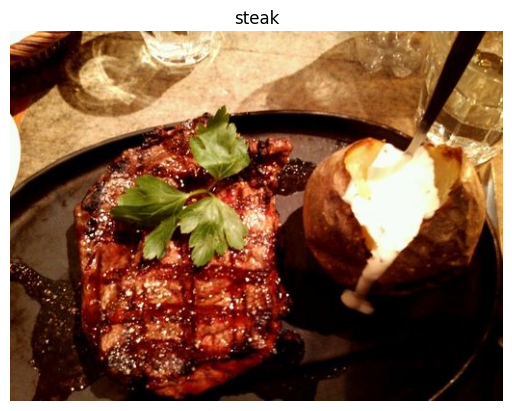

In [7]:
img = view_random_image("pizza_steak/train/","steak")

After going through a dozen or so images from the different classes, you can start to get an idea of what we're working with.

The entire Food101 dataset comprises of similar images from 101 different classes.

You might've noticed we've been printing the image shape alongside the plotted image.

This is because the way our computer sees the image is in the form of a big array (tensor).

In [8]:
img

array([[[237, 255, 255],
        [239, 255, 254],
        [240, 255, 252],
        ...,
        [160, 105,  38],
        [148,  93,  26],
        [141,  86,  19]],

       [[242, 254, 252],
        [242, 254, 252],
        [243, 254, 250],
        ...,
        [144,  89,  22],
        [138,  83,  16],
        [139,  84,  17]],

       [[249, 251, 246],
        [249, 251, 246],
        [249, 252, 245],
        ...,
        [137,  82,  15],
        [139,  84,  17],
        [150,  95,  28]],

       ...,

       [[ 90,  53,  24],
        [ 91,  54,  25],
        [ 93,  56,  27],
        ...,
        [ 10,   0,   0],
        [ 10,   0,   0],
        [ 10,   0,   0]],

       [[ 94,  57,  28],
        [ 94,  57,  28],
        [ 94,  57,  28],
        ...,
        [ 10,   0,   0],
        [ 10,   0,   0],
        [ 10,   0,   0]],

       [[ 92,  55,  26],
        [ 91,  54,  25],
        [ 92,  55,  26],
        ...,
        [ 10,   0,   0],
        [ 10,   0,   0],
        [ 10,   0,   0]]

In [9]:
# View the image shape
img.shape # returns (width, height, colour channels)

(384, 512, 3)

Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of [red, green and blue (RGB) pixels](https://en.wikipedia.org/wiki/RGB_color_model).

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of `pizza` and `steak`, it will be finding patterns in these different pixel values which determine what each class looks like.

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [10]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.92941176, 1.        , 1.        ],
        [0.9372549 , 1.        , 0.99607843],
        [0.94117647, 1.        , 0.98823529],
        ...,
        [0.62745098, 0.41176471, 0.14901961],
        [0.58039216, 0.36470588, 0.10196078],
        [0.55294118, 0.3372549 , 0.0745098 ]],

       [[0.94901961, 0.99607843, 0.98823529],
        [0.94901961, 0.99607843, 0.98823529],
        [0.95294118, 0.99607843, 0.98039216],
        ...,
        [0.56470588, 0.34901961, 0.08627451],
        [0.54117647, 0.3254902 , 0.0627451 ],
        [0.54509804, 0.32941176, 0.06666667]],

       [[0.97647059, 0.98431373, 0.96470588],
        [0.97647059, 0.98431373, 0.96470588],
        [0.97647059, 0.98823529, 0.96078431],
        ...,
        [0.5372549 , 0.32156863, 0.05882353],
        [0.54509804, 0.32941176, 0.06666667],
        [0.58823529, 0.37254902, 0.10980392]],

       ...,

       [[0.35294118, 0.20784314, 0.09411765],
        [0.35686275, 0.21176471, 0.09803922],
        [0.36470588, 0

Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

## An end-to-end example

We've checked out our data and found there's 750 training images, as well as 250 test images per class and they're all of various different shapes. 

It's time to jump straight in the deep end.

Reading the [original dataset authors paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf), we see they used a [Random Forest machine learning model](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d) and averaged 50.76% accuracy at predicting what different foods different images had in them.

From now on, that 50.76% will be our baseline.

> 🔑 **Note:** A **baseline** is a score or evaluation metric you want to try and beat. Usually you'll start with a simple model, create a baseline and try to beat it by increasing the complexity of the model. A really fun way to learn machine learning is to find some kind of modelling paper with a published result and try to beat it.

The code in the following cell replicates and end-to-end way to model our `pizza_steak` dataset with a convolutional neural network (CNN) using the components listed above.

There will be a bunch of things you might not recognize but step through the code yourself and see if you can figure out what it's doing.

We'll go through each of the steps later on in the notebook.

For reference, the model we're using replicates TinyVGG, the computer vision architecture which fuels the [CNN explainer webpage](https://poloclub.github.io/cnn-explainer/).

> 📖 **Resource:** The architecture we're using below is a scaled-down version of [VGG-16](https://arxiv.org/abs/1505.06798), a convolutional neural network which came 2nd in the 2014 [ImageNet classification competition](http://image-net.org/).

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# set the seed
tf.random.set_seed(42)

# Preprocess the data (get all the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                  batch_size=32, # number of images to process at a time
                                  target_size=(224,224), # Convert all images to be (224 x 224)
                                  class_mode="binary", # Type of classification
                                  seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                  batch_size=32, # number of images to process at a time
                                  target_size=(224,224), # Convert all images to be (224 x 224)
                                  class_mode="binary", # Type of classification
                                  seed=42)

# Create a CNN model
model_1 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224,224,3)), # First layer specifies input shape (height, width,colour channels)
        tf.keras.layers.Conv2D(10,3, activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
        tf.keras.layers.Conv2D(10,3, activation="relu"),
        tf.keras.layers.Conv2D(10,3, activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=2),
        tf.keras.layers.Flatten(), # Flatten
        tf.keras.layers.Dense(1, activation="sigmoid") # Binary activation output
        ])

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1.fit(train_data, 
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 30s 622ms/step - loss: 0.5704 - accuracy: 0.6753 - val_loss: 0.4138 - val_accuracy: 0.8380
Epoch 2/5
47/47 [==============================] - 27s 579ms/step - loss: 0.4417 - accuracy: 0.8073 - val_loss: 0.3580 - val_accuracy: 0.8620
Epoch 3/5
47/47 [==============================] - 27s 577ms/step - loss: 0.4276 - accuracy: 0.8093 - val_loss: 0.4193 - val_accuracy: 0.8220
Epoch 4/5
47/47 [==============================] - 27s 580ms/step - loss: 0.3833 - accuracy: 0.8367 - val_loss: 0.4591 - val_accuracy: 0.7960
Epoch 5/5
47/47 [==============================] - 27s 570ms/step - loss: 0.3372 - accuracy: 0.8653 - val_loss: 0.3249 - val_accuracy: 0.8640


> 🤔 **Note:** If the cell above takes more than ~30 seconds per epoch to run, you might not be using a GPU accelerator. If you're using a Colab notebook, you can access a GPU accelerator by going to Runtime -> Change Runtime Type -> Hardware Accelerator and select "GPU". After doing so, you might have to rerun all of the above cells as changing the runtime type causes Colab to have to reset.


Nice! After 5 epochs, our model beat the baseline score of 50.76% accuracy (our model got ~88% accuaracy on the training set and ~86% accuracy on the test set).

However, our model only went through a binary classificaiton problem rather than all of the 101 classes in the Food101 dataset, so we can't directly compare these metrics. That being said, the results so far show that our model is learning something.

> 🛠 **Practice:** Step through each of the main blocks of code in the cell above, what do you think each is doing? It's okay if you're not sure, we'll go through this soon. In the meantime, spend 10-minutes playing around the incredible [CNN explainer website](https://poloclub.github.io/cnn-explainer/). What do you notice about the layer names at the top of the webpage?


Since we've already fit a model, let's check out its architecture.

In [12]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

What do you notice about the names of `model_1`'s layers and the layer names at the top of the [CNN explainer website](https://poloclub.github.io/cnn-explainer/)?

I'll let you in on a little secret: we've replicated the exact architecture they use for their model demo.

Look at you go! **You're already starting to replicate models you find in the wild.**

Now there are a few new things here we haven't discussed, namely: 
* The [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class and the `rescale` parameter
* The [`flow_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method
  * The `batch_size` parameter
  * The `target_size` parameter
* [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers (and the parameters which come with them)
* [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers (and their parameters).
* The `steps_per_epoch` and `validation_steps` parameters in the `fit()` function

Before we dive into each of these, let's see what happens if we try to fit a model we've worked with previously to our data.

## Using the same model as before

To examplify how neural networks can be adapted to many different problems, let's see how a binary classification model we've previously built might work with our data.

> 🔑 **Note:** If you haven't gone through the previous classification notebook, no troubles, we'll be bringing in the a simple 4 layer architecture used to separate dots replicated from the [TensorFlow Playground environment](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75075&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.
  * A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [14]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the Tensorflow playground model

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)), # dense layers expect 1-dimensional vector as input
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model

model_2.compile(loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])

# Fit the model

model_2.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 4s 83ms/step - loss: 2.4265 - accuracy: 0.6640 - val_loss: 0.7172 - val_accuracy: 0.7720
Epoch 2/5
47/47 [==============================] - 4s 82ms/step - loss: 0.8149 - accuracy: 0.7220 - val_loss: 0.5914 - val_accuracy: 0.7540
Epoch 3/5
47/47 [==============================] - 4s 80ms/step - loss: 0.7177 - accuracy: 0.7373 - val_loss: 0.7610 - val_accuracy: 0.7640
Epoch 4/5
47/47 [==============================] - 4s 80ms/step - loss: 0.6236 - accuracy: 0.7733 - val_loss: 1.1005 - val_accuracy: 0.6580
Epoch 5/5
47/47 [==============================] - 4s 78ms/step - loss: 0.5136 - accuracy: 0.7993 - val_loss: 2.4214 - val_accuracy: 0.5180


Hmmm... our model ran but it doesn't seem like it learned anything. It only reaches 50% accuracy on the training and test sets which in a binary classification problem is as good as guessing.

Let's see the architecture.

In [15]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 4)                 602116    
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Wow. One of the most noticeable things here is the much larger number of parameters in `model_2` versus `model_1`.

`model_2` has 602,141 trainable parameters where as `model_1` has only 31,101. And despite this difference, `model_1` still far and large out performs `model_2`.

> 🔑 **Note:** You can think of trainable parameters as *patterns a model can learn from data*. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different **features** in an image.

Since our previous model didn't work, do you have any ideas of how we might make it work?

How about we increase the number of layers? 

And maybe even increase the number of neurons in each layer?

More specifically, we'll increase the number of neurons (also called hidden units) in each dense layer from 4 to 100 and add an extra layer.

> 🔑 **Note:** Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the **complexity** of your model.

In [16]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 220ms/step - loss: 3.2676 - accuracy: 0.6260 - val_loss: 0.9090 - val_accuracy: 0.6900
Epoch 2/5
47/47 [==============================] - 10s 219ms/step - loss: 0.8288 - accuracy: 0.7073 - val_loss: 0.5639 - val_accuracy: 0.7580
Epoch 3/5
47/47 [==============================] - 11s 227ms/step - loss: 0.7103 - accuracy: 0.7353 - val_loss: 0.9622 - val_accuracy: 0.6700
Epoch 4/5
47/47 [==============================] - 10s 222ms/step - loss: 0.6492 - accuracy: 0.7607 - val_loss: 0.4349 - val_accuracy: 0.8000
Epoch 5/5
47/47 [==============================] - 10s 218ms/step - loss: 0.7098 - accuracy: 0.7380 - val_loss: 0.6873 - val_accuracy: 0.7440


Woah! Looks like our model is learning again. It got ~70% accuracy on the training set and ~70% accuracy on the validation set.

How does the architecute look?

In [17]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_7 (Dense)             (None, 100)               15052900  
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


My gosh, the number of trainable parameters has increased even more than `model_2`. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, `model_3` still doesn't out perform `model_1`.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.